- Subir Varma,
- Chapter 7 - Congestion Control in Data Center Networks,
- Editor(s): Subir Varma,
- Internet Congestion Control,
- Morgan Kaufmann,
- 2015,

https://www.sciencedirect.com/science/article/abs/pii/B9780128035832000074

# Building the fat tree Graph

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

def build_fat_tree(k=4):  # k is number of ports per switch, 4 => 16 servers
    G = nx.Graph()
    pods = k
    core_switches = (k // 2) ** 2
    agg_switches = k * (k // 2)
    edge_switches = k * (k // 2)
    servers = (k ** 3) // 4

    core_ids = [f'core_{i}' for i in range(core_switches)]
    agg_ids = [f'agg_{i}' for i in range(agg_switches)]
    edge_ids = [f'edge_{i}' for i in range(edge_switches)]
    server_ids = [f'server_{i}' for i in range(servers)]

    # Add switches and servers
    G.add_nodes_from(core_ids, type='core')
    G.add_nodes_from(agg_ids, type='agg')
    G.add_nodes_from(edge_ids, type='edge')
    G.add_nodes_from(server_ids, type='server')

    # Connect core to agg
    for i, core in enumerate(core_ids):
        for j in range(k):
            agg = agg_ids[j * (k // 2) + (i // (k // 2))]
            G.add_edge(core, agg)

    # Connect agg to edge
    for pod in range(pods):
        for i in range(k // 2):
            agg = agg_ids[pod * (k // 2) + i]
            for j in range(k // 2):
                edge = edge_ids[pod * (k // 2) + j]
                G.add_edge(agg, edge)

    # Connect edge to servers
    for i, edge in enumerate(edge_ids):
        for j in range(k // 2):  # 2 servers per edge
            server = server_ids[i * 2 + j]
            G.add_edge(edge, server)

    return G


In [42]:
def custom_fat_tree_layout(G):
    levels = {'core': 0, 'agg': 1, 'edge': 2, 'server': 3}
    pos = {}
    layer_counts = {'core': 0, 'agg': 0, 'edge': 0, 'server': 0}

    # Count how many nodes per layer to space evenly
    for node in G.nodes:
        ntype = G.nodes[node]['type']
        layer_counts[ntype] += 1

    # Track position within each layer
    x_positions = {'core': 0, 'agg': 0, 'edge': 0, 'server': 0}

    # Define spacing
    spacing = 3

    # Set positions
    for ntype in ['core', 'agg', 'edge', 'server']:
        count = layer_counts[ntype]
        for node in [n for n in G.nodes if G.nodes[n]['type'] == ntype]:
            x = x_positions[ntype] * spacing
            y = -levels[ntype] * spacing
            pos[node] = (x, y)
            x_positions[ntype] += 1

    return pos


# Routing Algorithms

In [43]:
class ECMP_Routing:
    def __init__(self, G):
        self.G = G
        self.route_cache = {}  # {(src, dst): {'paths': [...], 'index': 0}}

    def round_robin(self, src, dst):
        key = (src, dst)

        # If not cached, calculate and store all shortest paths
        if key not in self.route_cache:
            all_paths = list(nx.all_shortest_paths(self.G, src, dst))
            self.route_cache[key] = {
                'paths': all_paths,
                'index': 0
            }

        # Fetch current path
        path_data = self.route_cache[key]
        path = path_data['paths'][path_data['index']]

        # Update index for next time (round robin)
        path_data['index'] = (path_data['index'] + 1) % len(path_data['paths'])

        return path

    def simple_ecmp_routing(self, G, src, dst):
        all_paths = list(nx.all_shortest_paths(G, src, dst))
        chosen_path = all_paths[0]
        return chosen_path

    


# Helper function for visualising the fat tree

In [44]:
def visualize_routing(G, path):
    pos = custom_fat_tree_layout(G)
    plt.figure(figsize=(20, 7))

    # Draw all nodes
    color_map = {'core': 'red', 'agg': 'orange', 'edge': 'green', 'server': 'blue'}
    for ntype in ['core', 'agg', 'edge', 'server']:
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[n for n in G.nodes if G.nodes[n]['type'] == ntype],
                               node_color=color_map[ntype],
                               label=ntype, node_size=300)

    # Draw all edges
    nx.draw_networkx_edges(G, pos, alpha=1)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Highlight path
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='cyan', width=7)

    plt.title("ECMP Routing Path")
    plt.axis('off')
    plt.legend()
    plt.show()


# Simple ECMP Routing that can cause congestion

Selected path from server_1 to server_14: ['server_1', 'edge_0', 'agg_0', 'core_0', 'agg_6', 'edge_7', 'server_14']


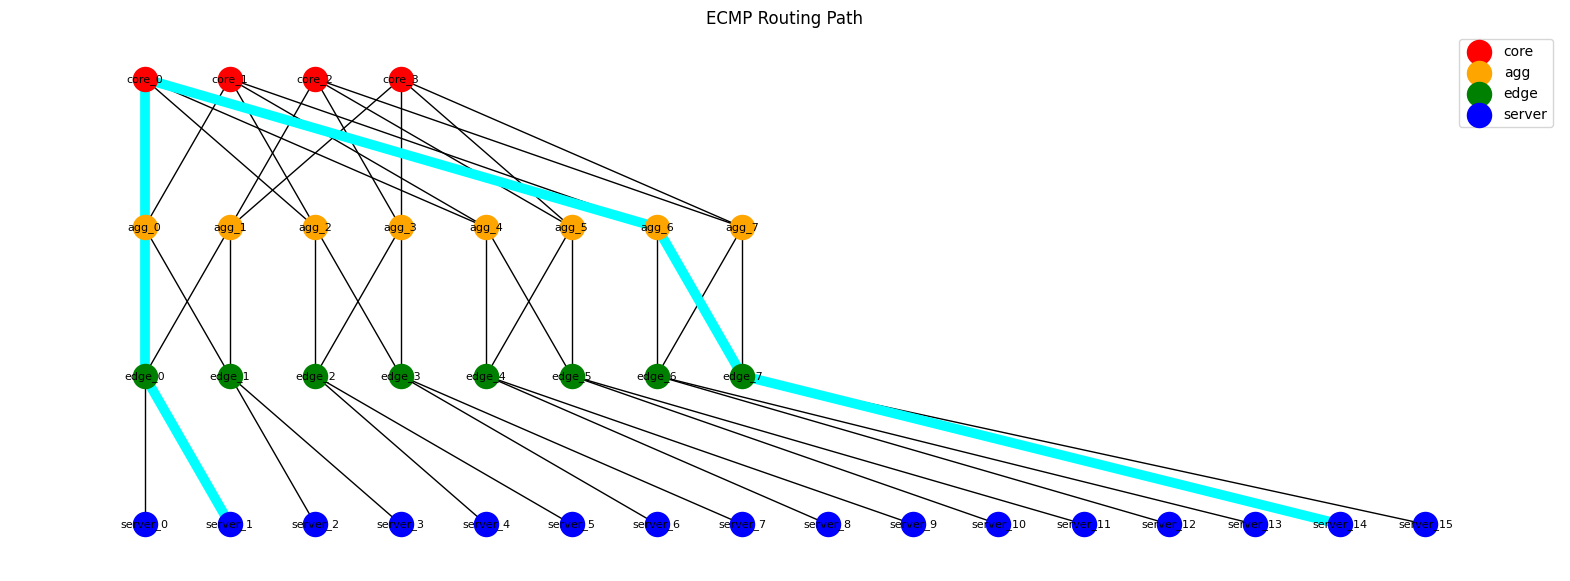

In [45]:
G = build_fat_tree(k=4)
ECMP = ECMP_Routing(G)
src = 'server_1'
dst = 'server_14'
path = ECMP.simple_ecmp_routing(G, src, dst)
print(f"Selected path from {src} to {dst}: {path}")
visualize_routing(G, path)


# Round robin approach that equally distributes the network load

Using path: ['server_1', 'edge_0', 'agg_0', 'core_0', 'agg_6', 'edge_7', 'server_14']


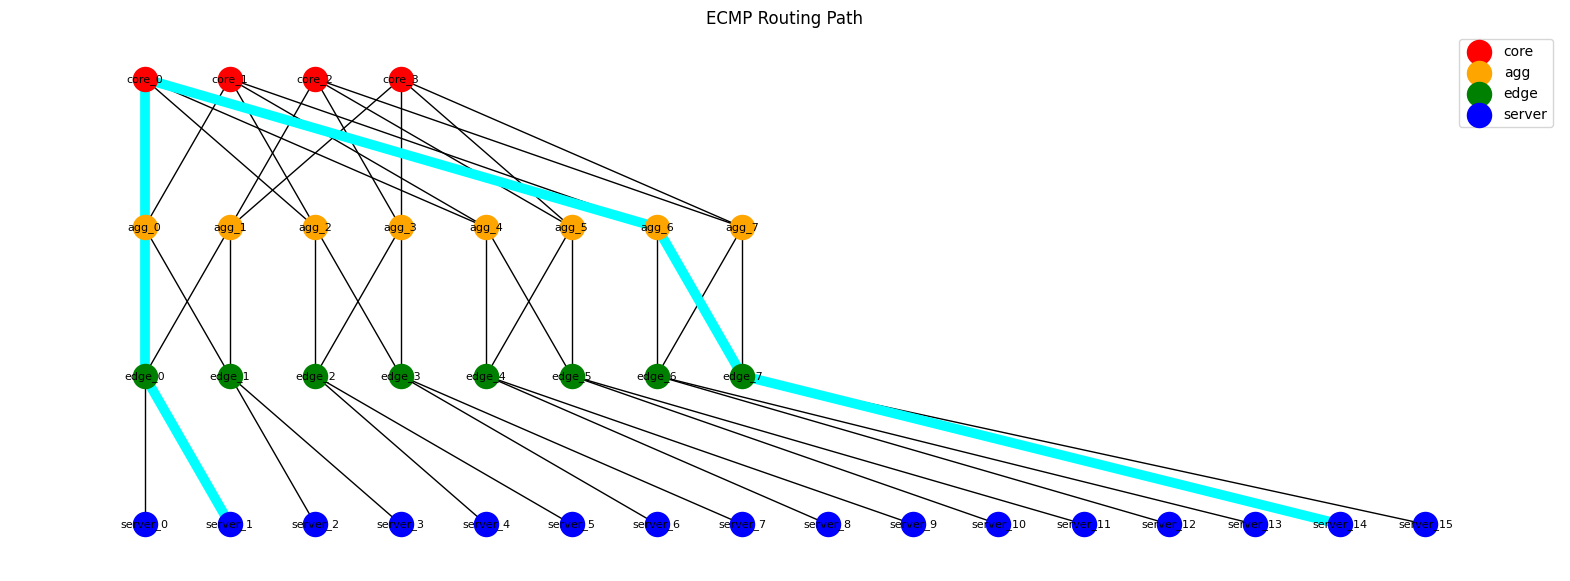

Using path: ['server_1', 'edge_0', 'agg_0', 'core_1', 'agg_6', 'edge_7', 'server_14']


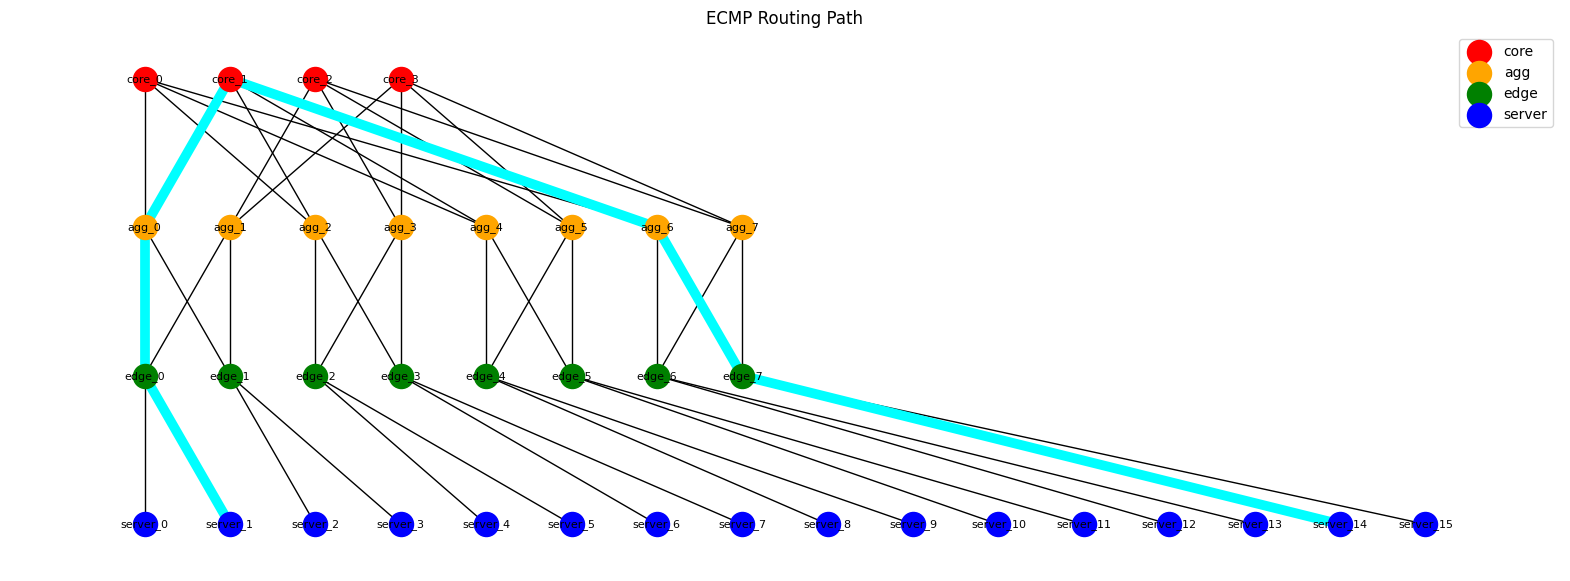

Using path: ['server_1', 'edge_0', 'agg_1', 'core_2', 'agg_7', 'edge_7', 'server_14']


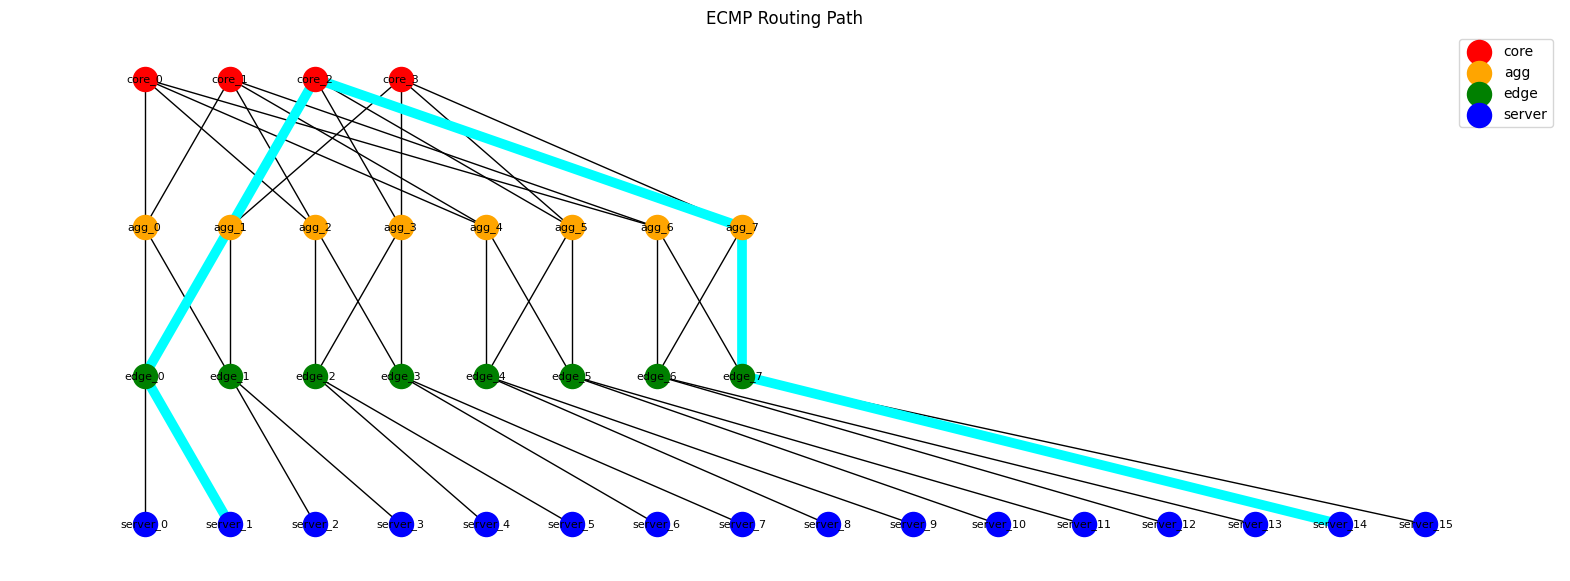

Using path: ['server_1', 'edge_0', 'agg_1', 'core_3', 'agg_7', 'edge_7', 'server_14']


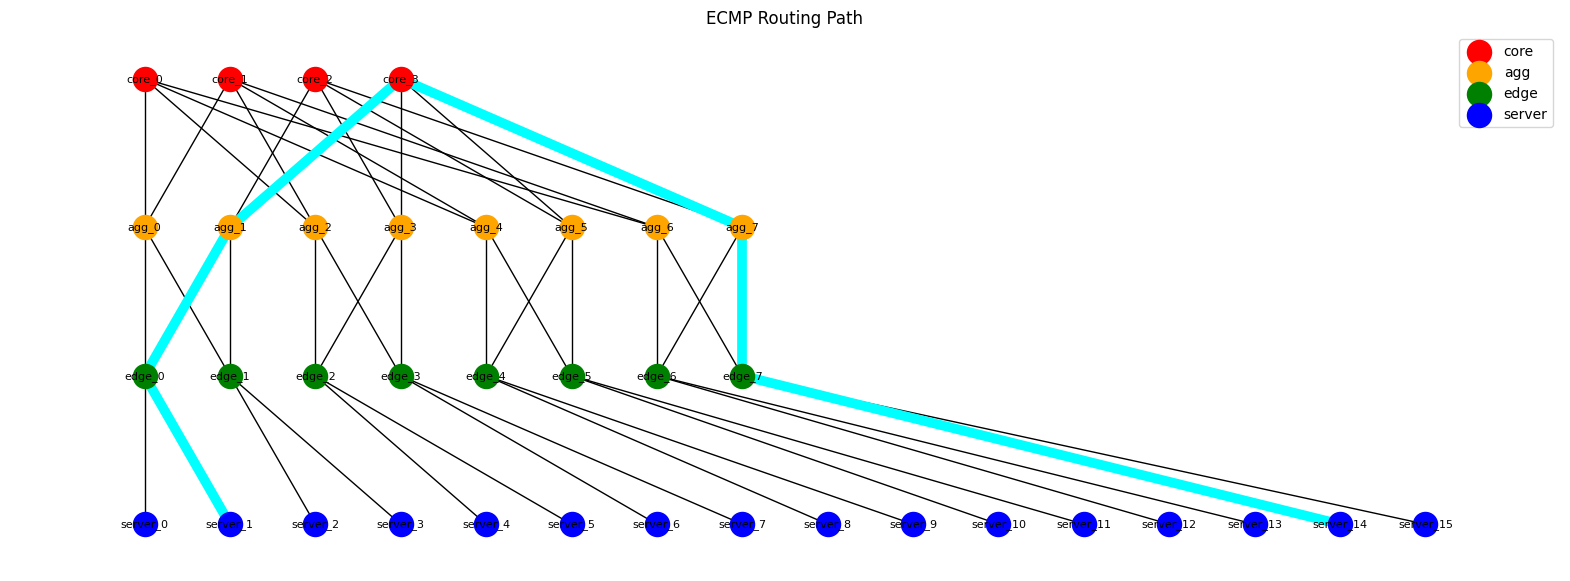

Using path: ['server_1', 'edge_0', 'agg_0', 'core_0', 'agg_6', 'edge_7', 'server_14']


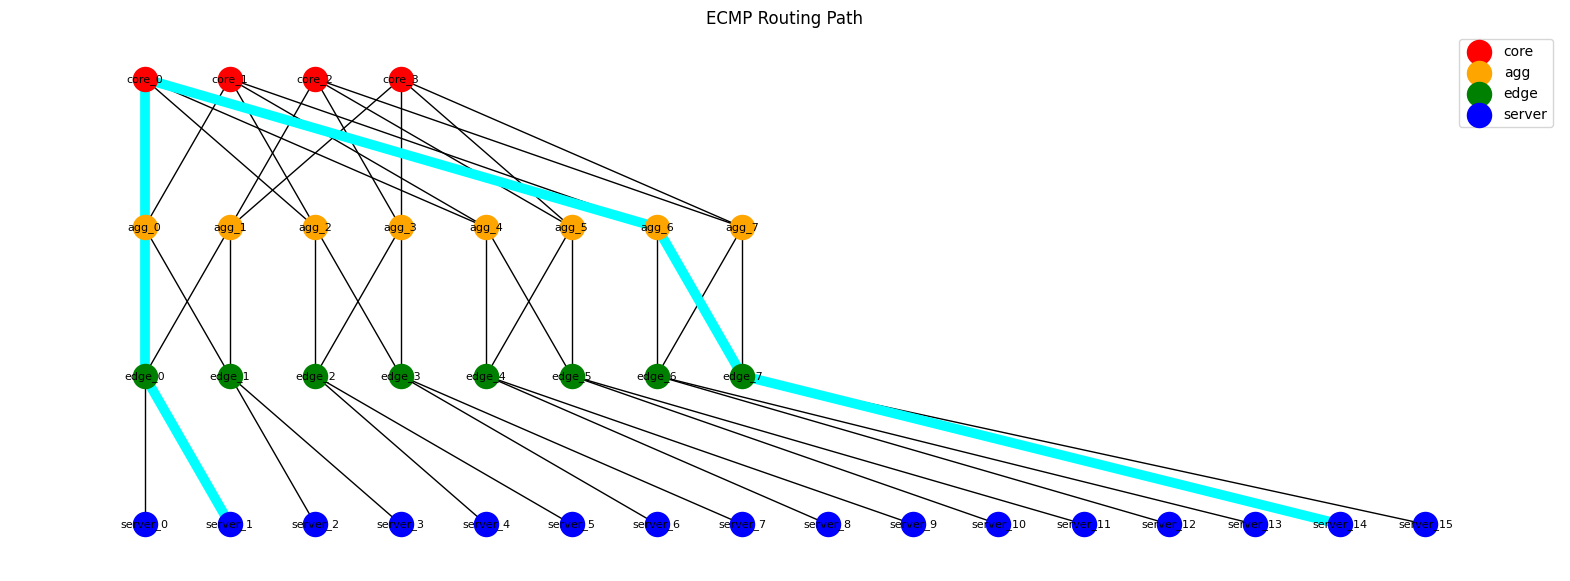

Using path: ['server_1', 'edge_0', 'agg_0', 'core_1', 'agg_6', 'edge_7', 'server_14']


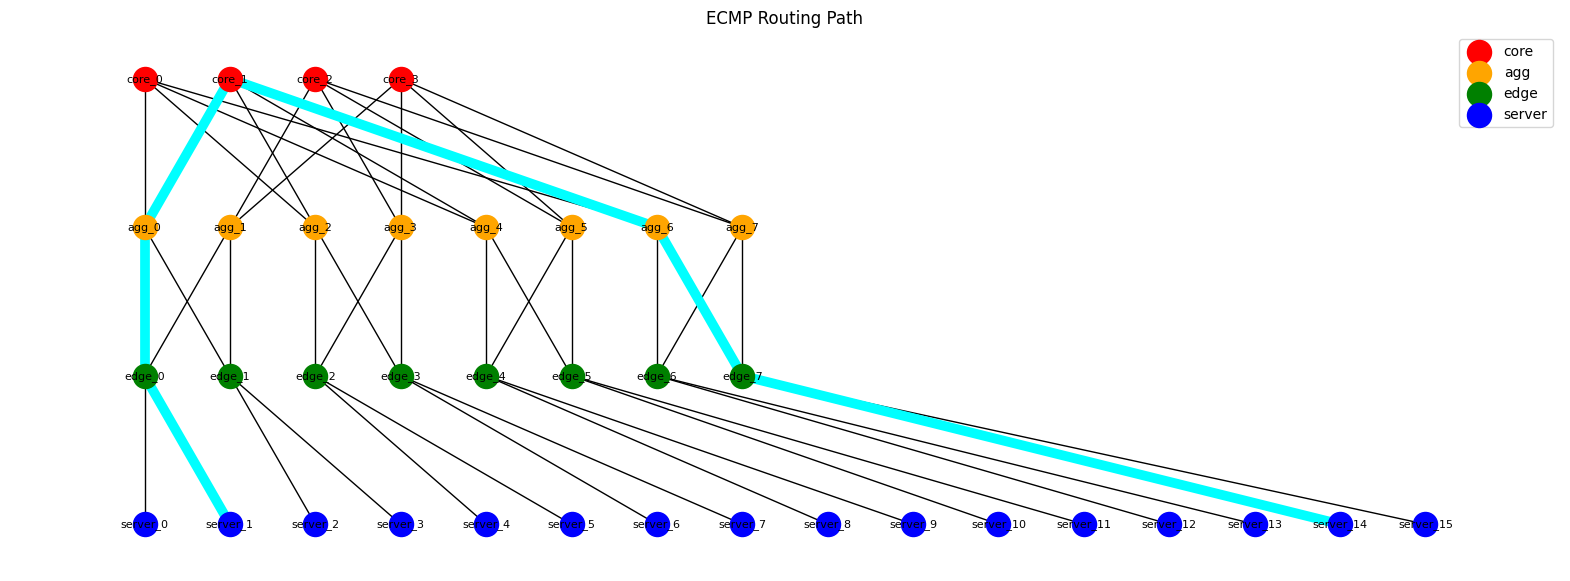

In [46]:
G = build_fat_tree(k=4)

src = 'server_1'
dst = 'server_14'

num_of_requests=6

# Simulate multiple calls cycling through shortest paths
for _ in range(num_of_requests):
    path = ECMP.round_robin(src, dst)
    print(f"Using path: {path}")
    visualize_routing(G, path)    

